# Prepare code for change point analysis

Metrics:
- density overturning stream function
- depth overturning stream function
- barotropic stream function

Process:
1. compute metric
2. calculate ensemble mean
3. subtract mean from each member
4. change point analysis

# HERE MOC
- ## time series
- ensemble mean
- subtract mean
- change point

In [1]:
### INITIALISATION ###

import numpy as np          # fundamental package for scientific computing
import xarray as xr         # data handling
import glob                 # return all file paths that match a specific pattern
import os                   # provide operating system-related functions
import pop_tools            # to mask region of interest
import gsw                  # compute potential density

path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/vvel/'
salt_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/salt/'
temp_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/'
files = glob.glob(path + '*.nc')

grid_name = 'POP_gx1v7'

#setting up of regional mask
region_defs = {
    'NorthAtlantic':[{'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [-20.0, 66.0]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}],
    'MediterraneanSea': [{'match': {'REGION_MASK': [7]}}]} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
mask3d = mask3d.sum('region')

# prepare arrays and dictionaries to store files
len_time = 3012 # length of time series
dens_time_series_maxi = np.zeros((len_time, len(files)))  # array for min bsf
dens_time_series_rapi = np.zeros((len_time, len(files))) # array for rapid
dept_time_series_maxi = np.zeros((len_time, len(files)))  # array for min bsf
dept_time_series_rapi = np.zeros((len_time, len(files))) # array for rapid


# target sigam levels
sigma_level = [12. , 16. , 20. , 24. , 28. , 28.5 , 29.2 , 29.4 , 29.6 , 29.8 , 30. , 30.2 , 30.4 , 30.6 , 
                       30.8 , 31. , 31.2 , 31.4 , 31.6 , 31.8 , 32. , 32.2 , 32.4 , 32.6 , 32.8 , 33. , 33.2 , 33.4 , 
                       33.6 , 33.8 , 34. , 34.2 , 34.4 , 34.6 , 34.8 , 35. , 35.2 , 35.4 , 35.6 , 35.8 , 36.1 , 36.2 , 
                       36.3 , 36.4 , 36.55, 36.6 , 36.65, 36.7 , 36.72, 36.74, 36.76, 36.78, 36.8 , 36.82, 36.84, 
                       36.86, 36.88, 36.9 , 36.92, 36.94, 36.96, 36.98, 37. , 37.02, 37.04, 37.06, 37.08, 37.1 , 
                       37.12, 37.14, 37.16, 37.18, 37.2 , 37.25, 37.3 , 37.35, 37.4 , 37.45, 37.6 , 37.7 , 37.8 , 
                       37.9 , 38. , 39. , 40. , 41. , 42.]

print('initialisation complete')

ModuleNotFoundError: No module named 'gsw'

# Test duration of codes
1. xarray mask + numpy computation
2. numpy mask + numpy computation
3. xarray mask + xarray computation

For depth and density

depth

In [2]:
import time

In [5]:
start_time = time.time()

i=0
ds = xr.open_dataset(files[i]).isel(time=slice(0,100)).where(mask3d == 1)

# Transform units into SI units
np_VVEL_mps = ds.VVEL.values *1e-2  # Convert cm/s to m/s
np_dz_m = ds.dz.values *1e-2  # Convert cm to m
np_dx_m = ds.DXU.values *1e-2  # Convert cm to m

# integrate over longitude
np_V_t_nao = np.nansum(np_VVEL_mps * np_dx_m * np_dz_m, axis=2)
# intgrate over depth
np_psi_nao = np.nancumsum(np_V_t_nao, axis=0) * 1e-6  # Convert m^3/s to Sv

print("--- %s seconds ---" % (time.time() - start_time))

--- 32.734649658203125 seconds ---


In [3]:
import numpy.ma as ma
mask = mask3d.values
mask_vvel = np.tile(mask, [100, 60, 1, 1])
ds_ini =  xr.open_dataset(files[0]).isel(time=0).where(mask3d == 1)
np_dz_m = ds_ini.dz.values *1e-2  # Convert cm to m
np_dx_m = ds_ini.DXU.values *1e-2  # Convert cm to m

In [4]:
start_time2 = time.time()

i=0
np_VVEL_mps = xr.open_dataset(files[i]).isel(time=slice(0,100)).VVEL.values
np_VVEL_mps = ma.masked_array(np_VVEL_mps, mask=mask_vvel)
np_VVEL_mps = np_VVEL_mps *1e-2 

# integrate over longitude
np_V_t_nao = np.nansum(np_VVEL_mps * np_dx_m * np_dz_m, axis=2)
# intgrate over depth
np_psi_nao = np.nancumsum(np_V_t_nao, axis=0) * 1e-6  # Convert m^3/s to Sv

print("--- %s seconds ---" % (time.time() - start_time2))

--- 44.98364496231079 seconds ---


In [6]:
start_time3 = time.time()

i=0
ds = xr.open_dataset(files[i]).isel(time=slice(0,100)).where(mask3d == 1)

### compute overturning in depth space
overturning_depth = (ds.VVEL * ds.dz * ds.DXU).sum(dim='nlon').cumsum(dim='z_t') * 1e-6
# compute maximum time series
maxi = overturning_depth.isel(z_t=slice(27, 51)).max(dim=['nlat','z_t']).values
# compute RAPID time series
rapi = overturning_depth.isel(nlat=274, z_t=slice(27, 51)).max(dim='z_t').values

print("--- %s seconds ---" % (time.time() - start_time3))

--- 30.814529180526733 seconds ---


density

In [ ]:
min_lat=110
max_lat=370

In [ ]:
start_time4 = time.time()

ds = xr.open_dataset(files[i])

# select relevant time step of dataset
ds_t = ds.isel(time=t)
# prepare array
overturning = np.zeros([len(sigma_level), (max_lat-min_lat)])

for j in range(min_lat,max_lat):
    # prepare transport array
    sigma_transport = np.zeros(len(sigma_level))

    ### compute velocity transport
    v_transport = (ds_t.VVEL.isel(nlat=j) * ds_t.dz.isel(nlat=j) * ds_t.DXU.isel(nlat=j)).values

    ### get sigma vlaues for selected cross section
    sigma_crossection = ds_t.SIGMA.isel(nlat=j).values

    ### sum over longitudes per sigm bin
    for i in range(len(sigma_level)-1):
        ind = np.where((sigma_crossection >= sigma_level[i]) & (sigma_crossection < sigma_level[i+1]))
        sigma_transport[i] = np.nansum(v_transport[ind])

    print('overturning at nlat' + str(j) + ': ' + np.cumsum(sigma_transport)[::-1] * 1e-6)

    
print("--- %s seconds ---" % (time.time() - start_time3))

# Routine

In [67]:
def depth_MOC(ds):
    
    ### compute overturning in depth space
    overturning_depth = (ds.VVEL * ds.dz * ds.DXU).sum(dim='nlon').cumsum(dim='z_t') * 1e-6
    # compute maximum time series
    maxi = overturning_depth.isel(z_t=slice(27, 51)).max(dim=['nlat','z_t']).values
    # compute RAPID time series
    rapi = overturning_depth.isel(nlat=274, z_t=slice(27, 51)).max(dim='z_t').values
    
    return maxi, rapi

def density_MOC(ds):
    
    ### compute potential density
    # Conservative Temperature
    CT = gsw.conversions.CT_from_pt(ds.SALT, ds.TEMP)
    # Potential density
    ds['SIGMA'] = gsw.density.sigma2(ds.SALT, CT)
    ds['SIGMA'].attrs['units'] = 'kg/m^3 - 1000'
    
    len_time = 3

    min_lat=110
    max_lat=370
    
    maxi = np.zeros(len_time)
    rapi = np.zeros(len_time)
    
    for t in range(len_time):
        
        # select relevant time step of dataset
        ds_t = ds.isel(time=t)
        # prepare array
        overturning = np.zeros([len(sigma_level), (max_lat-min_lat)])

        for j in range(min_lat,max_lat):
            # prepare transport array
            sigma_transport = np.zeros(len(sigma_level))

            ### compute velocity transport
            v_transport = (ds_t.VVEL.isel(nlat=j) * ds_t.dz.isel(nlat=j) * ds_t.DXU.isel(nlat=j)).values

            ### get sigma vlaues for selected cross section
            sigma_crossection = ds_t.SIGMA.isel(nlat=j).values

            ### sum over longitudes per sigm bin
            for i in range(len(sigma_level)-1):
                ind = np.where((sigma_crossection >= sigma_level[i]) & (sigma_crossection < sigma_level[i+1]))
                sigma_transport[i] = np.nansum(v_transport[ind])

            ## compute overturning
            overturning[:,j-min_lat] = np.cumsum(sigma_transport)[::-1] * 1e-6
            overturning[:,j-min_lat] = overturning[:,j-min_lat][::-1]
        
        # compute maximum time series of time step
        maxi[t] = np.max(overturning)
        # compute RAPID time series of time step
        rapi[t] = np.max(overturning[:,274-min_lat])
    
    return maxi, rapi

In [69]:
### COMPUTATION ###

# loop through list of files
for i in range(4):#len(files)):
    # read in file abnd apply mask
    ds = xr.open_dataset(files[i]).isel(time=slice(0,3)).where(mask3d == 1)
    
    ### Update units to SI units
    # Convert the units and update the data variable 'RHO' and 'VVEL'
    ds['VVEL'] = ds.VVEL *1e-2
    ds['dz'] = ds.dz *1e-2
    ds['z_t'] = ds.z_t *1e-2
    ds['z_w_top'] = ds.z_w_top *1e-2
    ds['z_w_bot'] = ds.z_w_bot *1e-2
    ds['DXU'] = ds.DXU *1e-2
    # Update the attribute for new units
    ds['VVEL'].attrs['units'] = 'm/s'
    ds['dz'].attrs['units'] = 'm'
    ds['z_t'].attrs['units'] = 'm'
    ds['z_w_top'].attrs['units'] = 'm'
    ds['z_w_bot'].attrs['units'] = 'm'
    ds['DXU'].attrs['units'] = 'm'
    
    # depth MOC metrics
    dept_time_series_maxi[:3,i], dept_time_series_rapi[:3,i] = depth_MOC(ds)
    
    # density MOC metrics
    
    salt = salt_path + 'salt_' + files[i][-11:]
    temp = temp_path + 'temp_' + files[i][-11:]
    
    if os.path.exists(salt) and os.path.exists(temp):
        # load salt data set
        ds_salt = xr.open_dataset(salt).isel(time=slice(0,3)).where(mask3d == 1)
        # load temp data set
        ds_temp = xr.open_dataset(temp).isel(time=slice(0,3)).where(mask3d == 1)

        # add salt and temp to ds
        ds.update(ds_salt[["SALT"]])
        ds.update(ds_temp[["TEMP"]])
        
        dens_time_series_maxi[:3,i], dens_time_series_rapi[:3,i] = density_MOC(ds)
        
    print('file ', str(i), '/', str(len(files)), ' executed')
    
print('execution finished')

file  0 / 81  executed
file  1 / 81  executed
file  2 / 81  executed
file  3 / 81  executed
execution finished


# test depth code

In [1]:
#!/usr/bin/env python3
# inagler 12/09/23

### INITIALISATION ###

import numpy as np          # fundamental package for scientific computing
import xarray as xr         # data handling
import glob                 # return all file paths that match a specific pattern
import pop_tools            # to mask region of interest

path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/vvel/'
files = glob.glob(path + '*.nc')

grid_name = 'POP_gx1v7'

#setting up of regional mask
region_defs = {
    'NorthAtlantic':[{'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [-20.0, 66.0]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}],
    'MediterraneanSea': [{'match': {'REGION_MASK': [7]}}]} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
mask3d = mask3d.sum('region')

# prepare arrays and dictionaries to store files
len_time = 3012 # length of time series
dept_time_series_maxi = np.zeros((len_time, len(files)))  # array for min bsf
dept_time_series_rapi = np.zeros((len_time, len(files))) # array for rapid
dept_time_series_spgy = np.zeros((len_time, len(files))) # array for spg

print('initialisation complete')

def depth_MOC(ds):
    
    ### compute overturning in depth space
    overturning_depth = (ds.VVEL * ds.dz * ds.DXU).sum(dim='nlon').cumsum(dim='z_t') * 1e-6
    print('file ', str(i), ' overturning computed')
    # compute maximum time series
    maxi = overturning_depth.isel(z_t=slice(27, 51)).max(dim=['nlat','z_t']).values
    # compute RAPID time series
    rapi = overturning_depth.isel(nlat=274, z_t=slice(27, 51)).max(dim='z_t').values
    # compute SPG time series
    spgy = overturning_depth.isel(nlat=345, z_t=slice(27, 51)).max(dim='z_t').values
    
    return maxi, rapi, spgy

### COMPUTATION ###

# loop through list of files
for i in range(2):#len(files)):
    # read in file abnd apply mask
    ds = xr.open_dataset(files[i]).where(mask3d == 1).isel(time=slice(0,3))
    
    print('file ', str(i), ' loaded')
    
    ### Update units to SI units
    # Convert the units and update the data variable 'RHO' and 'VVEL'
    ds['VVEL'] = ds.VVEL *1e-2
    ds['dz'] = ds.dz *1e-2
    ds['z_t'] = ds.z_t *1e-2
    ds['z_w_top'] = ds.z_w_top *1e-2
    ds['z_w_bot'] = ds.z_w_bot *1e-2
    ds['DXU'] = ds.DXU *1e-2
    # Update the attribute for new units
    ds['VVEL'].attrs['units'] = 'm/s'
    ds['dz'].attrs['units'] = 'm'
    ds['z_t'].attrs['units'] = 'm'
    ds['z_w_top'].attrs['units'] = 'm'
    ds['z_w_bot'].attrs['units'] = 'm'
    ds['DXU'].attrs['units'] = 'm'
    
    print('file ', str(i), ' units adjusted')
    
    # depth MOC metrics
    dept_time_series_maxi[:3,i], dept_time_series_rapi[:3,i], dept_time_series_spgy[:3,i] = depth_MOC(ds)
        
    print('file ', str(i), '/', str(len(files)), ' executed')

print('computation finished')

### OUTPUT ###

# Save time series to a single file
#np.save("timeseries/maxi_dens_time_series.npy", dens_time_series_maxi)
#np.save("timeseries/rapi_dens_time_series.npy", dens_time_series_rapi)
#np.save("timeseries/spgy_dens_time_series.npy", dens_time_series_spgy)

print('saving successful')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


initialisation complete
file  0  loaded
file  0  units adjusted
file  0  overturning computed
file  0 / 81  executed
file  1  loaded
file  1  units adjusted
file  1  overturning computed
file  1 / 81  executed
computation finished
saving successful


# test density code

In [5]:
#!/usr/bin/env python3
# inagler 12/09/23

### INITIALISATION ###

import numpy as np          # fundamental package for scientific computing
import xarray as xr         # data handling
import glob                 # return all file paths that match a specific pattern
import os                   # provide operating system-related functions
import pop_tools            # to mask region of interest
import gsw                  # compute potential density

path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/vvel/'
salt_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/salt/'
temp_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/'
files = glob.glob(path + '*.nc')

grid_name = 'POP_gx1v7'

#setting up of regional mask
region_defs = {
    'NorthAtlantic':[{'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [-20.0, 66.0]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}],
    'MediterraneanSea': [{'match': {'REGION_MASK': [7]}}]} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
mask3d = mask3d.sum('region')

# prepare arrays and dictionaries to store files
len_time = 3012 # length of time series
intervall = 251 # to reduce compation time
dens_time_series_maxi = np.zeros((len_time, len(files)))  # array for min bsf
dens_time_series_rapi = np.zeros((len_time, len(files))) # array for rapid
dens_time_series_spgy = np.zeros((len_time, len(files))) # array for spg

# target sigam levels
sigma_level = [12. , 16. , 20. , 24. , 28. , 28.5 , 29.2 , 29.4 , 29.6 , 29.8 , 30. , 30.2 , 30.4 , 30.6 , 
                       30.8 , 31. , 31.2 , 31.4 , 31.6 , 31.8 , 32. , 32.2 , 32.4 , 32.6 , 32.8 , 33. , 33.2 , 33.4 , 
                       33.6 , 33.8 , 34. , 34.2 , 34.4 , 34.6 , 34.8 , 35. , 35.2 , 35.4 , 35.6 , 35.8 , 36.1 , 36.2 , 
                       36.3 , 36.4 , 36.55, 36.6 , 36.65, 36.7 , 36.72, 36.74, 36.76, 36.78, 36.8 , 36.82, 36.84, 
                       36.86, 36.88, 36.9 , 36.92, 36.94, 36.96, 36.98, 37. , 37.02, 37.04, 37.06, 37.08, 37.1 , 
                       37.12, 37.14, 37.16, 37.18, 37.2 , 37.25, 37.3 , 37.35, 37.4 , 37.45, 37.6 , 37.7 , 37.8 , 
                       37.9 , 38. , 39. , 40. , 41. , 42.]

print('initialisation complete')

def density_MOC(ds):

    min_lat=110
    max_lat=370
    
    maxi = np.zeros(10)
    rapi = np.zeros(10)
    spgy = np.zeros(10)
    
    for t in range(10):
        
        # select relevant time step of dataset
        ds_t = ds.isel(time=t)
        # prepare array
        overturning = np.zeros([len(sigma_level), (max_lat-min_lat)])

        for j in range(min_lat,max_lat):
            # prepare transport array
            sigma_transport = np.zeros(len(sigma_level))

            ### compute velocity transport
            v_transport = (ds_t.VVEL.isel(nlat=j) * ds_t.dz.isel(nlat=j) * ds_t.DXU.isel(nlat=j)).values

            ### get sigma vlaues for selected cross section
            sigma_crossection = ds_t.SIGMA.isel(nlat=j).values

            ### sum over longitudes per sigm bin
            for i in range(len(sigma_level)-1):
                ind = np.where((sigma_crossection >= sigma_level[i]) & (sigma_crossection < sigma_level[i+1]))
                sigma_transport[i] = np.nansum(v_transport[ind])

            ## compute overturning
            overturning[:,j-min_lat] = np.cumsum(sigma_transport)[::-1] #* 1e-6
            overturning[:,j-min_lat] = overturning[:,j-min_lat][::-1]
        
        # compute maximum time series of time step
        maxi[t] = np.max(overturning)
        # compute RAPID time series of time step
        rapi[t] = np.max(overturning[:,274-min_lat])
        # compute RAPID time series of time step
        spgy[t] = np.max(overturning[:,345-min_lat])
    
    return maxi, rapi, spgy

### COMPUTATION ###

# loop through list of files
for i in range(1):#len(files)):
    
    salt = salt_path + 'salt_' + files[i][-11:]
    temp = temp_path + 'temp_' + files[i][-11:]
    
    print(salt)
    print(temp)
    
    if os.path.exists(salt) and os.path.exists(temp):
        
        print('file ', str(i), '/', str(len(files)), ' exists')
    
        # read in file abnd apply mask
        ds = xr.open_dataset(files[i])
        
        print('file ', str(i), '/', str(len(files)), ' loaded')

        # load salt data set
        ds_salt = xr.open_dataset(salt)
        print('salt loaded')
        # load temp data set
        ds_temp = xr.open_dataset(temp)
        print('temp loaded')

        # add salt and temp to ds
        ds.update(ds_salt[["SALT"]])
        ds.update(ds_temp[["TEMP"]])
        
        print('salt and temp added')
            
        time = slice(0,10)

        ds_int = ds.isel(time=time).where(mask3d == 1)
        
        ### compute potential density
        # Conservative Temperature
        CT = gsw.conversions.CT_from_pt(ds_int.SALT, ds_int.TEMP)
        
        print('conservative temperature computed')
        
        # Potential density
        ds_int['SIGMA'] = gsw.density.sigma2(ds_int.SALT, CT)
        #ds['SIGMA'].attrs['units'] = 'kg/m^3 - 1000'
        
        print('potential density computed')

        maxi, rapi, spgy = density_MOC(ds_int)

        print('file ', str(i), '/', str(len(files)), ' executed')

initialisation complete
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/salt/salt_1301.019.nc
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1301.019.nc
file  0 / 81  exists
file  0 / 81  loaded
salt loaded
temp loaded
salt and temp added
conservative temperature computed
potential density computed
file  0 / 81  executed


# write routine to split up code

In [14]:
intervall = 1004
len_time = 3012 # length of time series
test = np.zeros((len_time))  # array for min bsf
  
k=0
for j in range(3):

    # read in file abnd apply mask
    #ds = xr.open_dataset(files[i]).isel(time=slice(0,intervall)).where(mask3d == 1)

    #maxi, rapi, spgy= depth_MOC(ds)


    #dept_time_series_maxi[k:k+intervall,i], dept_time_series_rapi[:intervall,i], dept_time_series_spgy[:intervall,i] 
    
    test[k:k+intervall] = 1

    print("Number of non-zero entries:", np.count_nonzero(test))

    k = k + intervall
    
    print(k)


Number of non-zero entries: 1004
1004
Number of non-zero entries: 2008
2008
Number of non-zero entries: 3012
3012


# Plot time series

In [1]:
import matplotlib.pyplot as plt
import numpy as np          # fundamental package for scientific computing

In [2]:
# Save time series to a single file
maxi = np.load("timeseries/maxi_dept_time_series_0.npy")
rapi = np.load("timeseries/rapi_dept_time_series_0.npy")
spgy = np.load("timeseries/spgy_dept_time_series_0.npy")

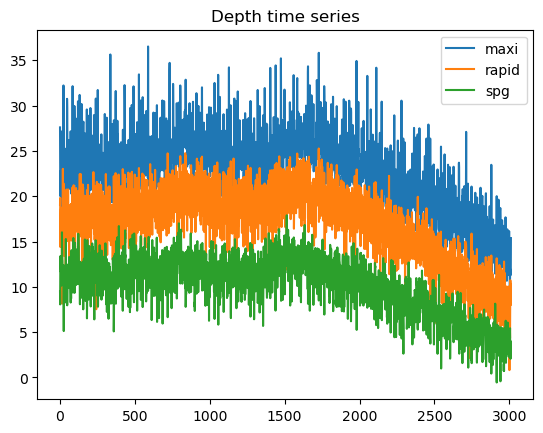

In [3]:
plt.title('Depth time series')
plt.plot(np.arange(0,len(maxi)), maxi, label='maxi')
plt.plot(np.arange(0,len(maxi)), rapi, label='rapid')
plt.plot(np.arange(0,len(maxi)), spgy, label='spg')
plt.legend()
plt.show()

In [3]:
# Save time series to a single file
maxi = np.load("timeseries/maxi_dens_time_series_0.npy")
rapi = np.load("timeseries/rapi_dens_time_series_0.npy")
spgy = np.load("timeseries/spgy_dens_time_series_0.npy")

In [4]:
maxi.shape

(3012,)

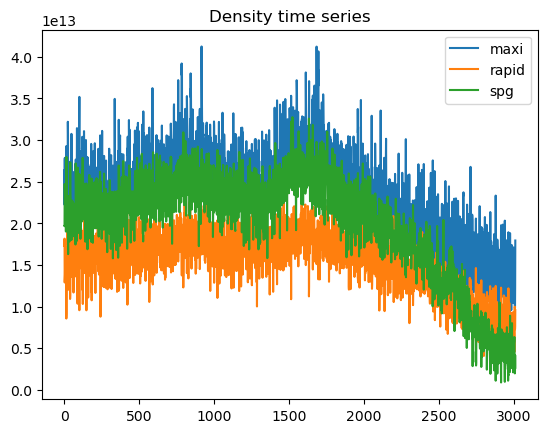

In [5]:
plt.title('Density time series')
plt.plot(np.arange(0,maxi.shape[0]), maxi, label='maxi')
plt.plot(np.arange(0,maxi.shape[0]), rapi, label='rapid')
plt.plot(np.arange(0,maxi.shape[0]), spgy, label='spg')
plt.legend()
plt.show()

In [6]:
# Reshape the data into 2D with 12 columns (12 months per year)
annual_data = maxi.reshape(-1, 12)

# Calculate the mean along axis 1 to get the annual means
annual_means = np.mean(annual_data, axis=1)

# Generate a time array for the timeseries data
time_annual = np.arange(1850, 1850 + len(annual_means))

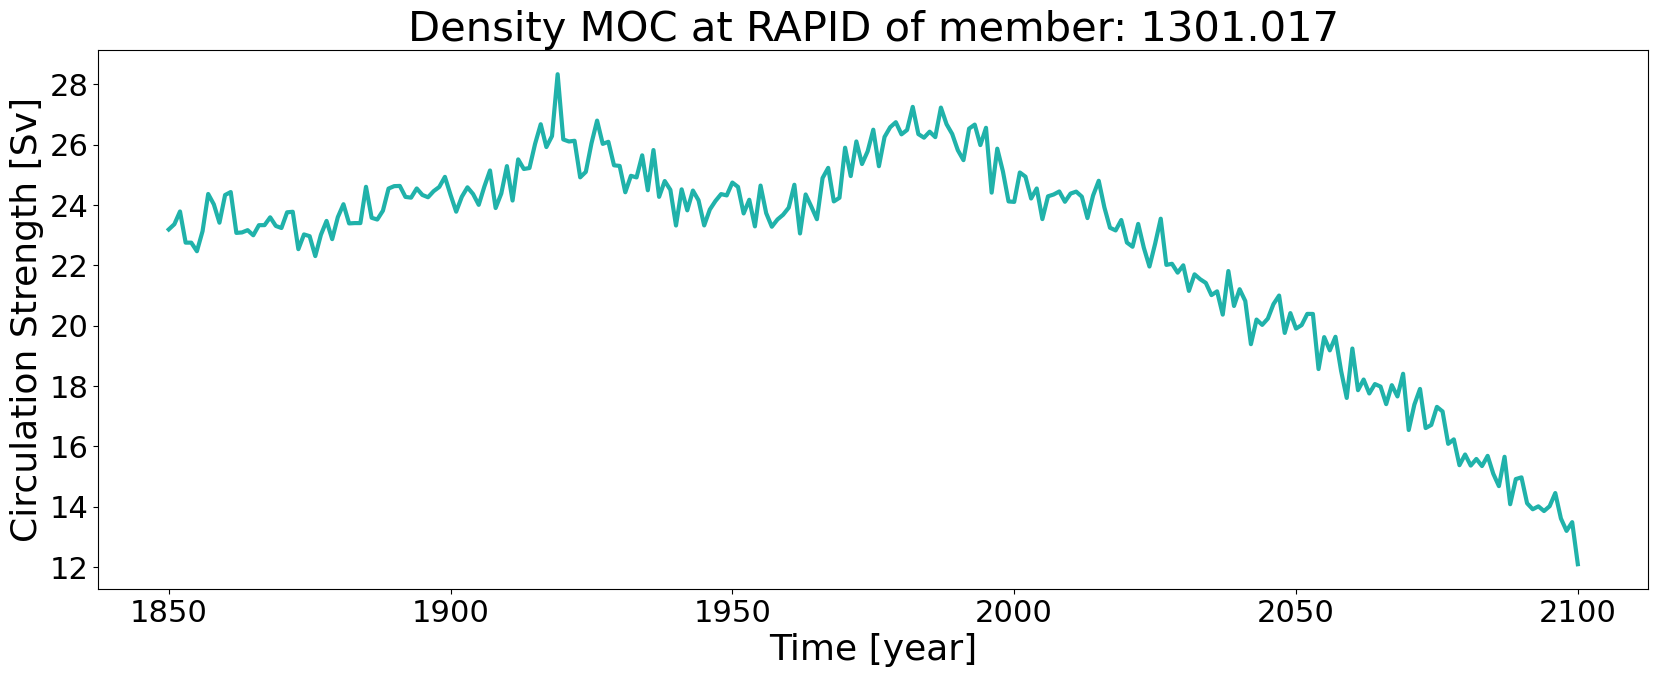

In [11]:
# Set the figure size
plt.figure(figsize=(20, 7))

# Plot MOC at RAPID timeseries
plt.plot(time_annual, annual_means, color ='lightseagreen', linewidth=3)

# Set the plot title
plt.title('Density MOC at RAPID of member: 1301.017', fontsize=30)
# Set the x-axis label
plt.xlabel('Time [year]', fontsize=26)
# Set the font size for x-axis tick labels
plt.xticks(fontsize=22)
# Set the x-axis label
plt.ylabel('Circulation Strength [Sv]', fontsize=26)
# Set the font size for x-axis tick labels
plt.yticks(fontsize=22)
# Display the plot
#plt.show()
plt.savefig('RAPID_dens_1301.017.png', dpi=300, bbox_inches='tight')

prepare parallel

In [5]:
#to prepare for parallel computing
num_parallel = [range(0, 5), range(5, 10), range(10, 15), range(15, 20), range(20, 25), range(25, 30), range(30, 35), range(35, 40),
               range(40, 45), range(45, 50), range(50, 55), range(55, 60), range(60, 65), range(65, 70), range(70, 75), range(75, 82)]

for j in range(16):
    for i in num_parallel[j]:
        print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
